In [3]:
import numpy as np
from matplotlib import pyplot as plt

### A more complex circuit (5 points)

In the problems above, you considered a simple $RC$ circuit. Now consider something a little more complicated:
<img src="http://www-personal.umich.edu/~gerdes/img/RC_1.jpg" height="400" width="400">
One can solve for the time constant, $\tau_c = (R2 + R1*R3/(R1 + R3))*C$, for charging the capacitor. Your task now is to model this circuit numerically using the same techniques as you employed for the simple $RC$ circuit(s) above. You can assume the values of the components are all known and can be passed to the `__init__`.  The capacitor will start uncharged at $t=0$.  Your goal is to find the charge $Q$ on the capacitor, and the three currents $I_1$, $I_2$, and $I_3$, as a function of time.

#### Using RCCircuit as a template for RCComplexCircuit
We define the class, `RCComplexCircuit` below. This will look virtually identical to `RCCircuit` with the following changes (in this line order):

- the `__init__` will need to take in arguments r1, r2, and r3 (not just a single resistance), then assign these to the attributes `self.r1`, `self.r2`, `self.r3`,
- the attribute `rc_constant`, as it is no longer just the product of resistance and capacitance for this circuit, but depends on r1, r2, r3, and capacitance (see previous paragraph)
- replace the first call of `_set_inow` in the `__init__` by defining only the attribute `i1_now`, given that the initial state of the circuit behaves as though there is no capacitor (e.g. $I_1(t=0)=V/R_{eq}$ where $R_{eq}=R_1+1/(1/R_2+1/R_3)$,
- you will need to have attributes for `i1_vals`, `i2_vals`, `i3_vals` (current through each resistor) defined in the init, whereas the simple RC circuit had only `i_vals`,) 
- the method `_set_inow` will need to set the attributes `i1_now`, `i2_now`, `i3_now`, whereas the simple RC circuit only had to set the attribute `i_now` (more on the system of equations shortly in the section **Calculating the current through each branch at each timestep**)  
- the `_set_inow` call in `evolve_circuit` should happen after `i1_vals` is populated, and before `i2_vals` is populated - you will see why from the next section on calculating the current through each branch
- the attribute `q_now` is updated according to the current running through this branch (i.e. `i2_now`)

#### Calculating the current through each branch at each timestep
If you are looking for more practice "solving a circuit", I recommend working through this one and solving for the currents.  Ultimately, you'll arrive at something along these lines:
\begin{eqnarray}
    I_2&=&(V - I_1*R_1 - Q_{cap}/C)/R_2   \\  
    I_3&=&(I_2*R_2 + Q_{cap}/C)/R_3     \\                      
    I_1&=&I_2 + I_3 \\
\end{eqnarray}
where the charge on the capacitor corresponds to the charge on the capacitor at a given timestep (i.e. `q_now`). You will want to define the method `_set_inow` by setting each current in this order.  Note, for a given next timestep, $I_2$ depends on $I_1$ and $Q_{cap}$ at the given timestep, $I_3$ depends on $I_2$ and $Q_{cap}$ at a given timestep, and the next timestep's $I_1$ is based on the new $I_2$ and $I_3$.

In [23]:
class RCComplexCircuit :
    """Creates an instance of a complex rc circuit model, which can be time evolved"""
### BEGIN SOLUTION
    def __init__(self, r1, r2, r3, capacitance, q_capacitor, voltage_battery) :
        """A model of an rc circuit
        Parameters
        ----------
        r1, r2, r3 : float
            value of resistance in ohms
        capacitance : float 
            value of capacitance in Farads
        q_capacitor : float
            initial charge on capacitor
        voltage_battery : float
            voltage across battery
        """

        self.r1 = r1
        self.r2 = r2
        self.r3 = r3
        self.capacitance = capacitance
        
        # The time constant is a characteristic timescale of the system, analogous to the period in a spring
        self.rc_constant = (r2 + r1*r3/(r1 + r3))*capacitance
        
        self.voltage_battery = voltage_battery
        self.q_now = q_capacitor
        
        self.i1_now = voltage_battery / (r1 + 1/(1/r2+1/r3))
        self.i2_now = self.i1_now * r3/(r2+r3)
        self.i3_now = self.i1_now * r2/(r2+r3)
        
        self.i1_vals = []
        self.i2_vals = []
        self.i3_vals = []
        self.q_vals = []

    def _set_i_now(self) :
        """Calculate current for attribute i?_now, for i1,)  i2, i3 in terms of other attributes"""
        self.i3_now = (self.i2_now * self.r2 + self.q_now/self.capacitance) / self.r3
        self.i2_now = (self.voltage_battery - self.i1_now * self.r1 - self.q_now/self.capacitance) / self.r2
        self.i1_now = self.i2_now + self.i3_now
        
        
    def _set_num_timesteps(self, num_timescales, num_timesteps_per_timescale) :        
        """Internal method. Sets the attributes num_timesteps and dt.
        Parameters
        ----------
        num_timescales : float
            number of timescales to evolve over
        num_timesteps_per_timescale : int
            number of timesteps per characteristic timescale, defines the time resolution 
        """
        
        dt = self.rc_constant / num_timesteps_per_timescale

        try :
            if self.dt != dt :
                # self.dt already exists, using evolve_spring with a different one
                print("Warning: you are continuing with a different timestep")
                print("previous dt=%.4f"%self.dt)
                print("new dt=%.4f"%dt)
                self.dt = dt
        except AttributeError :
            # Define the attribute dt for the first time
            self.dt = dt    
        
        self.num_timesteps = num_timescales * num_timesteps_per_timescale
        
    def evolve_circuit(self, num_timescales, num_timesteps_per_timescale) :
        """Evolve the spring, populate the acceleration, velocity and position (a_vals, v_vals, x_vals)
        Parameters
        ----------
        num_periods : float
            number of periods to evolve over
        num_timesteps_per_period : int
            number of timesteps per period, defines the time resolution         
        """
        
        self._set_num_timesteps(num_timescales, num_timesteps_per_timescale)
        
        for timestep in np.arange(self.num_timesteps) :
            
            # Populate i_vals and q_vals with current current and charge on capacitor
            self.i1_vals.append(self.i1_now)
            self._set_i_now()
            self.i2_vals.append(self.i2_now)
            self.i3_vals.append(self.i3_now)
            self.q_vals.append(self.q_now)
            
            # Update "now" values: q_now, and i_now (i_now can be updated with a method)
            self.q_now += self.i2_now * self.dt

### END SOLUTION

### Using your class

The code below assumes the class has been properly written, and defines an instance of the class that models the circuit for $R_1=10\Omega$, $R_2=20\Omega$, $R_3=15\Omega$, $C=1\mu$F, $Q_{0,cap}=0$C, and $V_{batt}=10$V.  We evolve the circuit over 5 time constants with 1000 steps per time constant.

In [24]:
complex_rc = RCComplexCircuit(10, 20, 15, 1e-6, 0, 10)
complex_rc.evolve_circuit(5, 1000)
print(complex_rc.i1_now, complex_rc.i2_now, complex_rc.i3_now)

0.40093408400310665 0.001555354784558105 0.39937872921854856


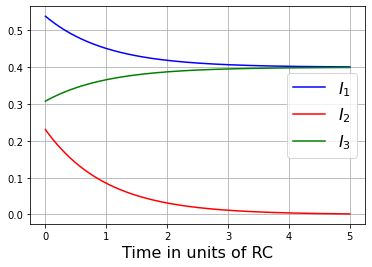

In [25]:
# Time evolution of current here
time_rc_units = np.arange(complex_rc.num_timesteps) * complex_rc.dt / complex_rc.rc_constant

plt.plot(time_rc_units, complex_rc.i1_vals, color='b', label='$I_1$')
plt.plot(time_rc_units, complex_rc.i2_vals, color='r', label='$I_2$')
plt.plot(time_rc_units, complex_rc.i3_vals, color='g', label='$I_3$')
plt.xlabel('Time in units of RC', fontsize=16)
plt.legend(fontsize=16)
plt.grid()